# imports

In [1]:
import thunderfish.dataloader as dl
import thunderfish.pulsetracker as pt
import thunderfish.eventdetection as ed
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

# parameters and functions


In [2]:
# parameters for the analysis
thresh = 0.04 # minimal threshold for peakdetection
peakwidth = 20 # width of a peak and minimal distance between two EODs

In [3]:
def plot_peaks(x,y,peaksx,peaksy,c='k'):
    plt.figure(figsize=(10,5))
    plt.plot(x,y,zorder=-1)
    plt.scatter(starttime + peaksx/data.samplerate,peaksy,c=c)
    plt.xlabel('time [s]')
    plt.ylabel('signal')
    
def plot_events_on_data(peaks, data):
    
    """
        plots the detected events onto the data timeseries. If the events are classified, the classes are plotted in different colors and the class -1 (not belonging to a cluster) is plotted in black
    """
    plt.plot(range(len(data)),data, color = 'black')
    if len(peaks)>3:
        classlist =  np.array(peaks[3],dtype=np.int)
        if len(peaks) > 4:
            classlist = np.array(peaks[4],dtype=np.int)
        cmap = plt.get_cmap('jet')
        colors =cmap(np.linspace(0, 1.0, 3000)) #len(np.unique(classlist))))
        np.random.seed(1)
        np.random.shuffle(colors)
        colors = [colors[cl] for cl in np.unique(classlist)]
        for cl, color in zip(np.unique(classlist), colors):
            if min(classlist) == 0 and cl == 0:
                color = 'black'
            if cl == -1:
                color = 'black'
            
            peaksofclass = peaks[:,classlist == cl]
            plt.plot(peaksofclass[0],peaksofclass[1], '.', color = color,   ms =20, label=cl)
    else:
        plt.scatter(peaks[0],peaks[1], color = 'red')
    plt.legend()
    plt.show()

# load data

In [4]:
# create list of filepaths..
text_file = open("leticia_filenames_sorted.txt", "r")
lines = text_file.read().split('\n')
i = 21

In [5]:
sub = '70917L01_G10_724'
print(['idx%i_%s'%(i,s) for i,s in enumerate(lines) if sub in s])

['idx90_70917L01_G10_724.WAV']


In [6]:
filepath = '/home/dexter/' + lines[i][:-4] + '/' + lines[i]

In [7]:
filepath

'/home/dexter/61107L01F14/61107L01F14.WAV'

In [8]:
starttime = 0
endtime = 60   #in seconds

with dl.open_data(filepath, -1, 1.0) as data:
    dt = 1/data.samplerate
    # do something with the content of the file:
    x = np.arange(starttime,endtime,dt)
    y = data[starttime*data.samplerate:endtime*data.samplerate,0]

# dexters final analysis code

In [9]:
eods = pt.analyze_pulse_data(filepath, starttime=starttime, endtime=endtime ,save=False)

blockamount:  2
0 % 

/home/liz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/liz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


returnes analyzed EODS. Calculate frequencies using all of these but discard the data from the EODS within the lowest few percent of amplitude


## plot of endresult

In [10]:
%matplotlib qt
plot_events_on_data(eods,y)

# pulse tracking detection step by step
## 1. EOD detection
### 1.1. Peak Detection
Detect peaks and troughs using a fixed, relative threshold according to Bryan S. Todd and David C. Andrews (1999): The identification of peaks in physiological signals.
Computers and Biomedical Research 32, 322-335.

In [11]:
%matplotlib inline

block1 = y[:int(len(y)/2)]
block2 = y[int(len(y)/2):]

block1x = x[:int(len(y)/2)]
block2x = x[int(len(y)/2):]

all_y = y

deltat = 30
nblock = int(deltat*data.samplerate)

In [14]:
y = block1
x = block1x

thresh_array = pt.create_threshold_array(y,3000,thresh)
pk, tr = ed.detect_peaks(y, thresh_array)

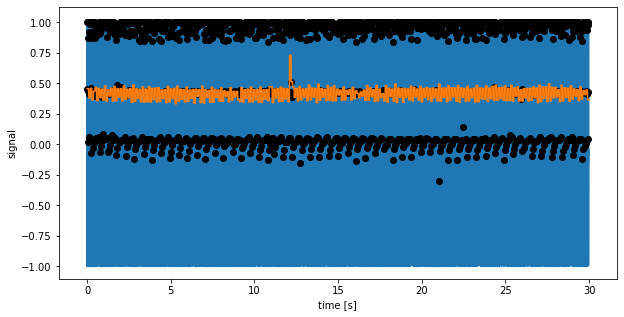

In [15]:
plot_peaks(x,y,pk,y[pk])
plt.plot(x,thresh_array)
#plot_peaks(x,y,tr,y[tr],'r')
#plt.plot(x,thresh_array)

### 1.2. EOD detection

#### 1.2.a delete peaks with no nearby throughts

Generate array of events that might be EODs of a pulse-type fish, using the location of peaks and troughs, the data and an optional width of an supposed EOD-event.
The generated event-array contains location and height of such events. The height of the events is calculated by its height-difference to nearby troughs and main events that have no side events in a range closer than event_width are discarded and not considered as EOD event.

No handles with labels found to put in legend.
/home/liz/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


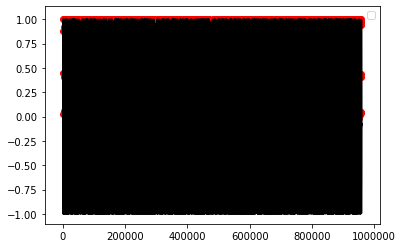

In [16]:
peaks = pt.makeeventlist(pk,tr,y,peakwidth)
plot_events_on_data(peaks,y)

#### 1.2.b delete multiples of peaks within one EOD timescale (keep only highest peak)
Given a number of events with given location and heights, returns a selection of these events where  no event is closer than eventwidth to the next event.
Among neighboring events closer than eventwidth the event with smaller height is discarded.

No handles with labels found to put in legend.


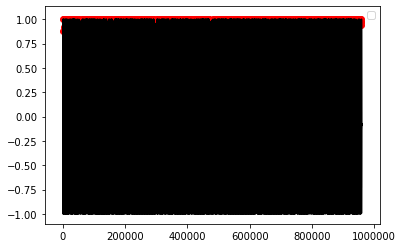

In [17]:
peakindices, peakx, peakh = pt.discardnearbyevents(peaks[0],peaks[1],peakwidth)
peaks = peaks[:,peakindices]
plot_events_on_data(peaks,y)

## 2. EOD Classification
### 2.1. Align EODs
cut intervals from a data array, interpolates and aligns them and returns them in a list

In [18]:
peaklist = pt.Peaklist([]) # idk why this has to happen here???

aligned_snips = pt.cut_snippets(y,peaks[0], 14, int_met = "cubic", int_fact = 10,max_offset = 1.5)

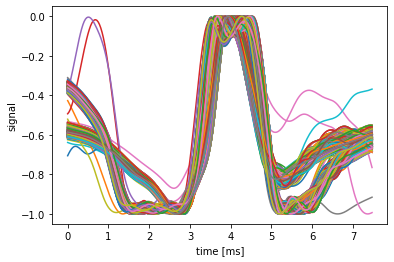

In [19]:
for eod in aligned_snips:
    plt.plot(1000*np.arange(0,len(eod)/data.samplerate,1/data.samplerate),eod)
    plt.xlabel('time [ms]')
    plt.ylabel('signal')

### 2.2. Determine PCA
Calculates the principal components of a dataset using the python module scikit-learn's principal component analysis

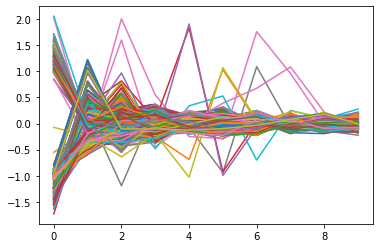

In [20]:
pcs = pt.pc(aligned_snips)
for pc in pcs:
    plt.plot(pc)

In [21]:
npol = 5
p = np.zeros((len(aligned_snips),npol+1))
x = range(len(aligned_snips[0]))
funcs = []

for i,s in enumerate(aligned_snips):
    cheb = np.polynomial.chebyshev.Chebyshev.fit(x,s,npol)
    funcs.append(cheb)
    p[i] = cheb.coef

In [22]:
pcs.shape

(899, 10)

### 2.3. cluster
cluster the given events using the given feature space and the clustering algorithm of choice and appends the assigned cluster number to the event's properties. Also minimum number of samples required for a class is given.

in this case DBSCAN method is used
DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

/home/liz/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


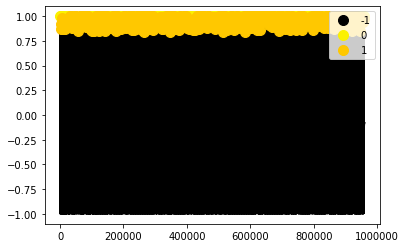

In [23]:
order = 5  # this decided how many PC dimensions are used, 
           # could be improved by choosing this dynamically 
           # or by looking as scree plot

minpeaks = 10
labels = pt.cluster_events(np.log(np.abs(p)), peaks, order, 0.4, minpeaks, False, method = 'DBSCAN')

# append labels to the peaks data
peaks = np.append(peaks,[labels], axis = 0)

plot_events_on_data(peaks,y)

### 2.4 amplitude classification
classifies peaks/EOD_events into different classes by their amplitude.
Takes list of peaks and list of properties of the list of the last analysis block
Classifies the single peaks in the direction of their occurence in time, based on their amplitude and their previously assigned class based on their waveform (... using the method cluster_events on the principal components of the snippets around the single peaks)
        
Method:
calculates differences in amplitude between the current peak and different amplitudeclasses that are nearby. 
Creates new amplitudeclass if no class is close enough. 
Peaks that are treated as noise by the dbscan algorithm but that do fit within a class amplitude-wise are added to the class, or a new class is generated for them.

In [24]:
peaks, peaklist = pt.ampwalkclassify3_refactor(peaks, peaklist)

/home/liz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/liz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


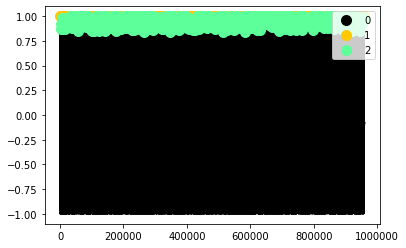

In [25]:
plot_events_on_data(peaks,y)

### 2.4.b discard short classes
Discard peakclasses that are less than minlen (as some peak classes may have been subdivided and thus shortened by the amplitude classification)

==> this function didn't work in the original code, I fixed it

(5, 899)


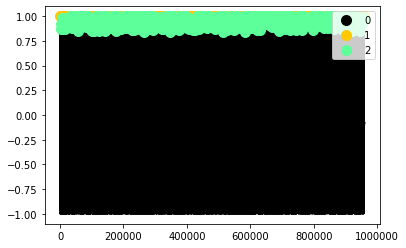

In [26]:
minlen = 6
peaks = pt.discard_short_classes(peaks, minlen)
print(peaks.shape)
plot_events_on_data(peaks,y)

### 2.4.c discard wave pulses
discards events from a pulse_event list which are unusally wide (wider than a tenth of the inter pulse interval), which indicates a wave-type EOD instead of a pulse type

(5, 899)


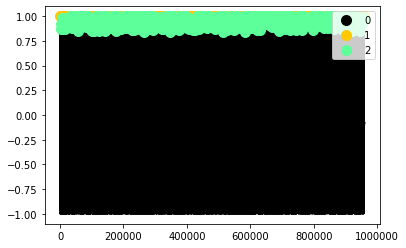

In [27]:
peaks = pt.discard_wave_pulses(peaks, y)
print(peaks.shape)
plot_events_on_data(peaks,y)

Save data from the analysis of the first block to later concatenate it to the analysis of the other data blocks

In [28]:
worldpeaks = np.copy(peaks)
worldpeaks[0] = worldpeaks[0]
# delete the classification that only considers wave shape.
thisblock_eods = np.delete(worldpeaks,3,0)
all_eods = thisblock_eods

peaklist.len = nblock

## 3. concatenating different blocks
### 3.1. classifying block 2 with the clustering

==> If I can save the values for the pc transormation and the previous  clustering model, I can also use that to concatenate and not only the blocks. 

/home/liz/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


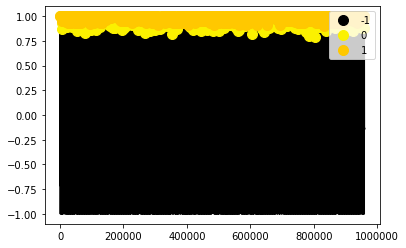

In [29]:
y = block2
x = block2x

thresh_array = pt.create_threshold_array(y,30000,thresh)
pk, tr = ed.detect_peaks(y, thresh_array)
peaks = pt.makeeventlist(pk,tr,y,peakwidth)
peakindices, peakx, peakh = pt.discardnearbyevents(peaks[0],peaks[1],peakwidth)
peaks = peaks[:,peakindices]

aligned_snips = pt.cut_snippets(y,peaks[0], 15, int_met = "cubic", int_fact = 10,max_offset = 1.5)
pcs = pt.pc(aligned_snips)

npol = 5
p = np.zeros((len(aligned_snips),npol+1))
x = range(len(aligned_snips[0]))
funcs = []

for i,s in enumerate(aligned_snips):
    cheb = np.polynomial.chebyshev.Chebyshev.fit(x,s,npol)
    funcs.append(cheb)
    p[i] = cheb.coef
    

order = 5  # this decided how many PC dimensions are used, 
           # could be improved by choosing this dynamically 
           # or by looking as scree plot

minpeaks = 10
labels = pt.cluster_events(np.log(np.abs(p)), peaks, order, 0.4, minpeaks, False, method = 'DBSCAN')

# append labels to the peaks data
peaks = np.append(peaks,[labels], axis = 0)

plot_events_on_data(peaks,y)

### 3.2. Connect block 1 and block 2
changes the labels of clusters in the current block to fit with the labels of the previous block.

For this, the ampwalk classifier classifies the first second of the next block using the data of the amplitude of the other peaks and the distance to them (NO DATA ON WAVESHAPE IS USED). By doing this, the pc classes are matched to the other ones by assuming they should be in the same ampwalk class. Could be improved by using waveshape data as well.

==> didn't work in all cases due to an error in the mapping code, fixed it.

In [30]:
peaklist = pt.connect_blocks(peaklist)
pt.alignclusterlabels(labels, peaklist, peaks,data=y)

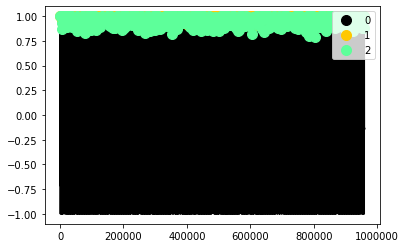

In [31]:
peaks, peaklist = pt.ampwalkclassify3_refactor(peaks, peaklist) # classification by amplitude
minlen = 6
peaks = pt.discard_short_classes(peaks, minlen)
plot_events_on_data(peaks,y)

### Plotting both blocks concatenated

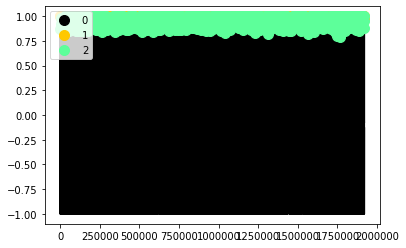

In [32]:
peaks[0] = peaks[0] + nblock
thisblock_eods = np.delete(peaks,3,0)
all_eods = np.concatenate((all_eods,thisblock_eods),axis = 1)
plot_events_on_data(all_eods,all_y)

In [33]:
%matplotlib qt
plot_events_on_data(all_eods,all_y)

- hermite and chebichev polinomials
- test code with using the same pca for each block
- delete classes where isis are too short
- merge based on polynomials
- do something about double peaks..

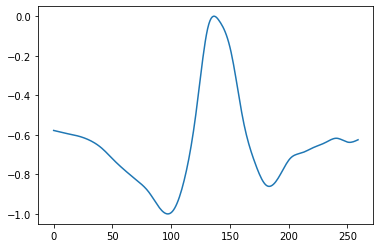

In [34]:
%matplotlib inline
plt.plot(aligned_snips[0])

In [35]:
x = range(-int(len(aligned_snips[0])/2),int(len(aligned_snips[0])/2))
y = aligned_snips[0]

p = np.polyfit(x,y,25)
f = np.poly1d(p)

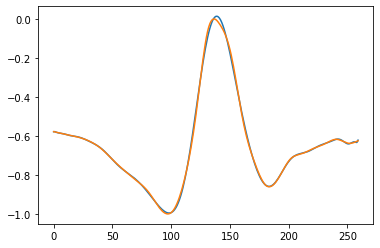

In [36]:
plt.plot(f(x))
plt.plot(aligned_snips[0])

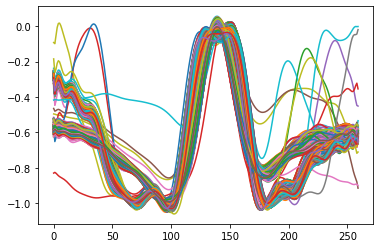

In [37]:
for eod in aligned_snips:
    p = np.polyfit(x,eod,25)
    f = np.poly1d(p)
    plt.plot(f(x))